In [1]:
import pandas as pd
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config
set_config(display="diagram")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time

In [2]:
url = "https://drive.google.com/file/d/1c5210z-HSQ-Kv4EExbYIjjPq6lT0UYZW/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
house = pd.read_csv(path)
house = house.sample(100).copy() # small sample to quickly test the pipeline

X = house.drop(columns=['Id','SalePrice'])
y = house['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Pipeline

In [ ]:
# numeric cols
num_cols = X_train.select_dtypes(exclude=['object']).columns

# ordinal cols
ord_cols = ['ExterQual','ExterCond','KitchenQual','FireplaceQu']
qualities = ["Po", "Fa", "TA", "Gd", "Ex"]
na_qualities = ["missing","Po", "Fa", "TA", "Gd", "Ex"]
ord_cols_categories = [qualities for l in range(3)] + [na_qualities]
assess: len(ord_cols) == len(ord_cols_categories)

# nominal cols
nom_cols = (
    X_train
    .drop(columns=ord_cols)
    .select_dtypes(include=['object'])
    .columns)


# numeric pipeline
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', MinMaxScaler())
])

# ordinal pipeline
ord_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value="missing")),
    ('encoder', OrdinalEncoder(handle_unknown="use_encoded_value",
                               unknown_value=-1)
    )
])

# nominal pipeline
nom_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value="missing")),
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

# preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipe, num_cols),
        ('nom', nom_pipe, nom_cols),
        ('ord', ord_pipe, ord_cols)
])

# Initialze the estimators
reg1 = RandomForestRegressor(random_state=42)
reg2 = LinearRegression()
reg3 = DecisionTreeRegressor(random_state=42)
reg4 = KNeighborsRegressor()
reg5 = GradientBoostingRegressor(random_state=42)

# model pipeline
model_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('var_threshold', VarianceThreshold()),
    ('mod_feature_sel', SelectFromModel(DecisionTreeRegressor())),
    # apply different models here
    ('regressor', reg1)
])

## Parameter grids

In [ ]:
# parameters for preprocessing pipeline
param_grid = {
    'preprocessor__ord__imputer__strategy': ['most_frequent', 'constant'],
    'preprocessor__nom__imputer__strategy': ['most_frequent', 'constant'],
    'var_threshold__threshold': [0, 0.01, 0.02],
    'mod_feature_sel__estimator__max_features': [None, 
                                                 'auto', 
                                                 'sqrt', 
                                                 'log2'],
    'mod_feature_sel__estimator__min_samples_leaf': [1, 2, 4]
}

# hyperparameters for each model
param1 = {}
param1["regressor__n_estimators"] = range(10, 250)
param1["regressor__max_depth"] = range(2, 12)
param1["regressor__max_features"] = ["sqrt", "log2", None]
param1["regressor"] = [reg1]

param2 = {}
param2["regressor"] = [reg2]

param3 = {}
param3["regressor__max_depth"] = range(3,12)
param3["regressor__min_samples_split"] = range(2,10)
param3["regressor"] = [reg3]

param4 = {}
param4["regressor__n_neighbors"] = range(1,30)
param4["regressor__weights"] = ["uniform", "distance"]
param4["regressor"] = [reg4]

param5 = {}
param5["regressor__learning_rate"] = [0.05, 0.1, 0.15]
param5["regressor"] = [reg5]

model_params = [param1, param2, param3, param4, param5]

# whole parameter grid
final_params_list = []

for i in range(len(model_params)):
  final_params = dict(model_params[i])
  final_params.update(param_grid)
  final_params_list.append(final_params)

## Cross Validation

In [ ]:
# randomized grid search + cross validation
grid_search = RandomizedSearchCV(model_pipe, 
                           final_params_list,
                           n_iter= 5000,
                           cv=5, 
                           random_state=42,
                           n_jobs=-1, 
                           verbose=2)

## Train model

In [ ]:
start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()
time_taken = (end_time - start_time)/60
print("--- %s minutes ---" % (time_taken))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
--- 43.59681595961253 minutes ---


# Error analysis

In [ ]:
grid_search.best_params_

{'var_threshold__threshold': 0.02,
 'regressor__n_estimators': 150,
 'regressor__max_features': 'sqrt',
 'regressor__max_depth': 11,
 'regressor': RandomForestRegressor(max_depth=11, max_features='sqrt', n_estimators=150,
                       random_state=42),
 'preprocessor__ord__imputer__strategy': 'most_frequent',
 'preprocessor__nom__imputer__strategy': 'constant',
 'mod_feature_sel__estimator__min_samples_leaf': 1,
 'mod_feature_sel__estimator__max_features': 'sqrt'}

In [ ]:
grid_search.best_score_

0.7171984672122235

In [ ]:
# get predictions
predictions_train = grid_search.predict(X_train)

# evaluate the model
print(f"R2 score: {r2_score(y_train, predictions_train)}")
print(f"MSE: {mean_squared_error(y_train, predictions_train)}")
print(f"MAE: {mean_absolute_error(y_train, predictions_train)}")


R2 score: 0.973447724713048
MSE: 168387905.32306856
MAE: 9367.162551256613


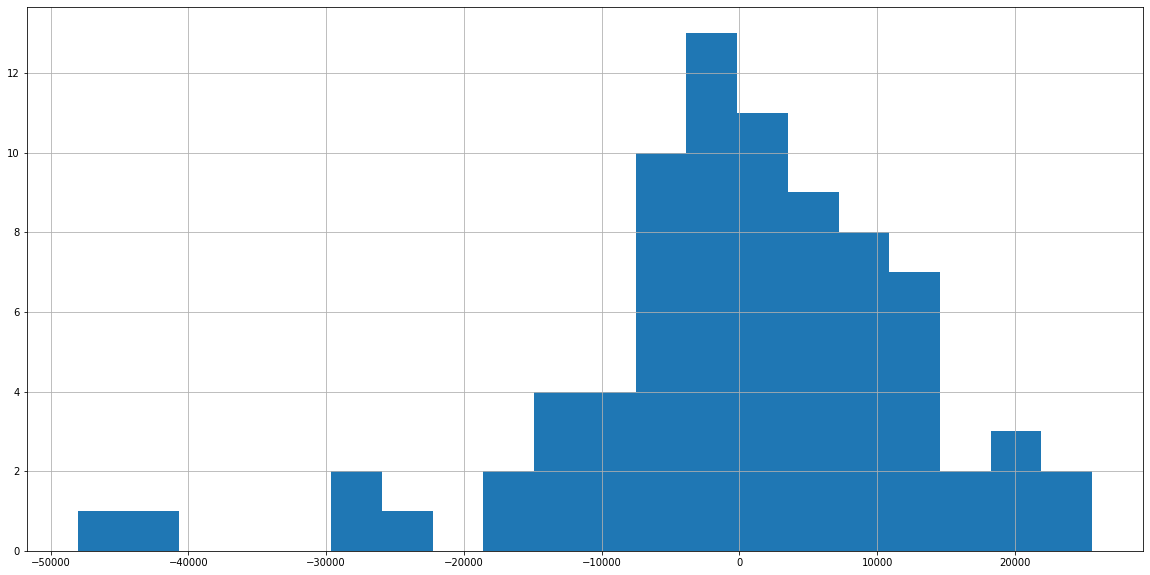

In [ ]:
# distribution of errors
(predictions_train - y_train).hist(bins=20, figsize=(20,10));

In [ ]:
# get predictions
predictions_test = grid_search.predict(X_test)

# evaluate the model
print(f"R2 score: {r2_score(y_test, predictions_test)}")
print(f"MSE: {mean_squared_error(y_test, predictions_test)}")
print(f"MAE: {mean_absolute_error(y_test, predictions_test)}")


R2 score: 0.8019404350757369
MSE: 892427100.3497162
MAE: 23783.738904761907


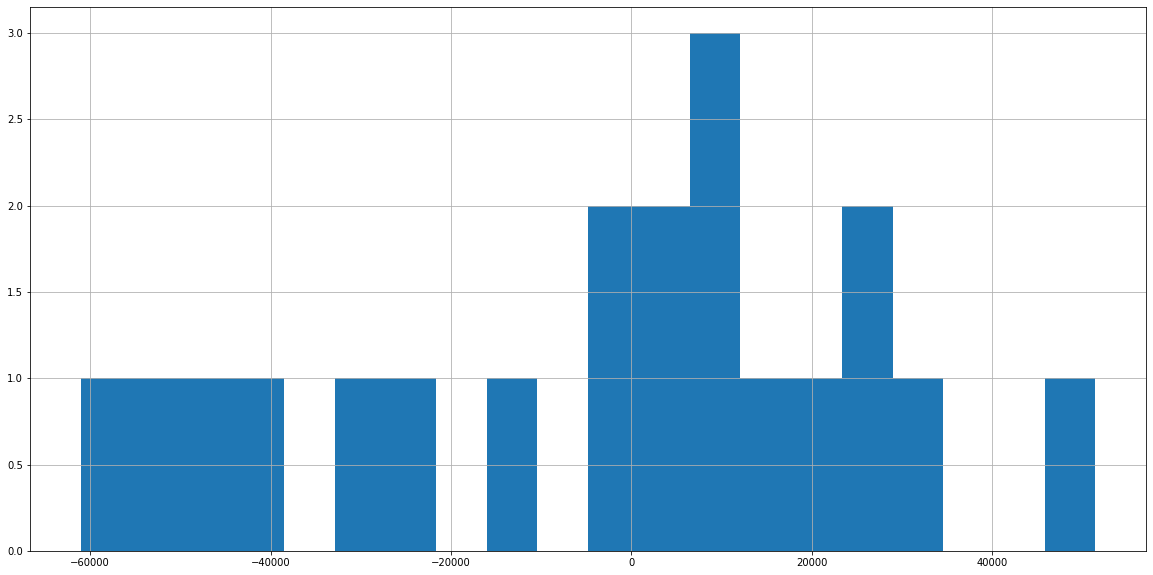

In [ ]:
# distribution of errors
(predictions_test - y_test).hist(bins=20, figsize=(20,10));